# Medical Segmentation Decathlon Liver EDA

## Generalisable 3D Semantic Segmentation using PyTorch: 

## By:

- Shlomo Kashani: shlomo@deeponcology.ai 

<img src="deep-onco-black.png"  style='float:center;max-width:50%;'>


## Progress

- [x] Nifti EDA
- [ ] PyTorch DataSet
- [ ] PyTorch DataLoader
- [ ] Augmentations
- [ ] Train loop

## References: 
- https://www.raddq.com/automated-ivc-filter-detection/
- https://www.kaggle.com/kmader/show-3d-nifti-images/code

## Download data

http://medicaldecathlon.com/


In [1]:
%reset -f 
%matplotlib inline


import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 


import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = 2222
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)

__Python VERSION: 3.6.2 (v3.6.2:5fd33b5, Jul  8 2017, 04:57:36) [MSC v.1900 64 bit (AMD64)]
__pyTorch VERSION: 0.4.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:32_Central_Daylight_Time_2017
Cuda compilation tools, release 9.0, V9.0.176
__CUDNN VERSION: 7005
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
USE CUDA=True


# Define  Data folders

In [2]:
import os
from glob import glob
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

dataset='data-splits1' 
dataset='Training Batch 1' 
data_dir= 'd:/db/data/seg/liver/'

BASE_IMG_PATH=os.path.join(data_dir,dataset)
print (BASE_IMG_PATH)

d:/db/data/seg/liver/Training Batch 1


# Nifti read 

In [3]:
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import nibabel as nifti
import os
import operator
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.filters import gaussian
from skimage.feature import match_template
from skimage.feature import peak_local_max
from sklearn.cluster import KMeans

def readScan(fileList, imgType='NIFTI', new_spacing=[5,1,1]):    
    #Read a NIFTI image - fileList is a file
    if imgType == 'NIFTI':
        niftiData = nifti.load(fileList)
        
        #Get the slice thickness and pixel spacing
        slice_thickness = niftiData.header.get_zooms()[2]
        print ("slice_thickness :{}".format(slice_thickness))
        pixel_spacing = list(niftiData.header.get_zooms()[:2])
        print ("pixel_spacing :{}".format(pixel_spacing))
        # Get the slope and intercept
        intercept = niftiData.dataobj.inter
        slope = niftiData.dataobj.slope
        
        #Get the actual image data
        image = np.array(niftiData.dataobj)
        #Shift the axis order to match what we expect (z,x,y) and
        #adjust to (0,0) in the upper right
        image = np.rollaxis(image, 2, 0)
        image = np.fliplr(np.flipud(np.swapaxes(image,1,2)))
    else:
        print ("Unspported format")
        return 
    # Calculate the desired resampling
    spacing = np.array(list(map(float, [slice_thickness] + 
                                        pixel_spacing)))

    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    return scipy.ndimage.interpolation.zoom(image, real_resize_factor)

def plotScan(scan, start_with, show_every, rows=3, cols=3, box = None):    
    fig,ax = plt.subplots(rows, cols, figsize=[3*cols,3*rows])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/cols), int(i%cols)].set_title('slice %d' % ind)
        ax[int(i/cols), int(i%cols)].axis('off')
        
        #Draw the scan cropping to the provided box
        if box:
            clipScan = scan[ind,box[2]-1:box[5],
                            box[1]-1:box[4]]
            ax[int(i/cols), int(i%cols)].imshow(clipScan,cmap='gray')
        else:
            ax[int(i/cols), int(i%cols)].imshow(scan[ind],cmap='gray')
    plt.show()
    

imageList = glob(BASE_IMG_PATH + '/**/*.nii', recursive=True)
print ( "Number of images: {}". format (len (imageList)))
for img in imageList[0:5]:
    print(img)

all_images=glob(BASE_IMG_PATH + '/volume-*.nii')
all_masks = [x.replace('volume-', 'segmentation-') for x in all_images]

print(len(all_images),' matching files found:',all_images[0], all_masks[0])

c:\users\gpu\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Number of images: 56
d:/db/data/seg/liver/Training Batch 1\segmentation-0.nii
d:/db/data/seg/liver/Training Batch 1\segmentation-1.nii
d:/db/data/seg/liver/Training Batch 1\segmentation-10.nii
d:/db/data/seg/liver/Training Batch 1\segmentation-11.nii
d:/db/data/seg/liver/Training Batch 1\segmentation-12.nii
28  matching files found: d:/db/data/seg/liver/Training Batch 1\volume-0.nii d:/db/data/seg/liver/Training Batch 1\segmentation-0.nii


## Print a grid of images

slice_thickness :5.0
pixel_spacing :[0.703125, 0.703125]


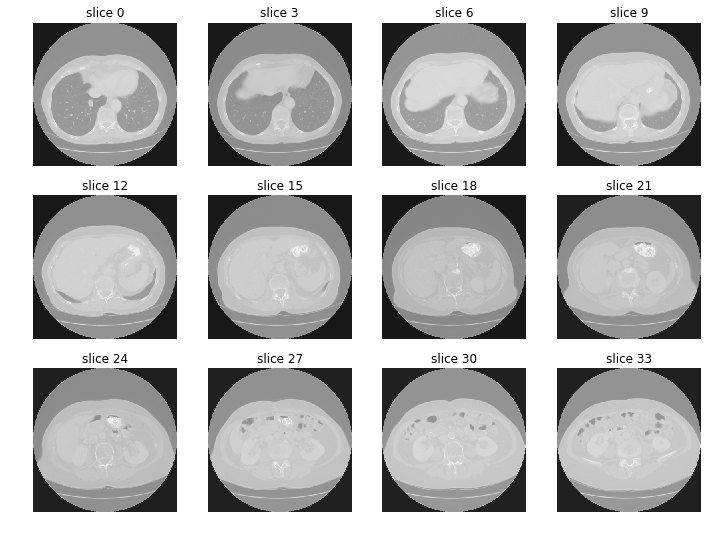

In [4]:
scan = readScan(all_images[0], imgType='NIFTI')
plotScan(scan, 0, 3,rows=3, cols=4)
# scan = readScan(all_masks[0], imgType='NIFTI')
# plotScan(scan, 0, 5, rows=3, cols=4)

## Print single image and mask

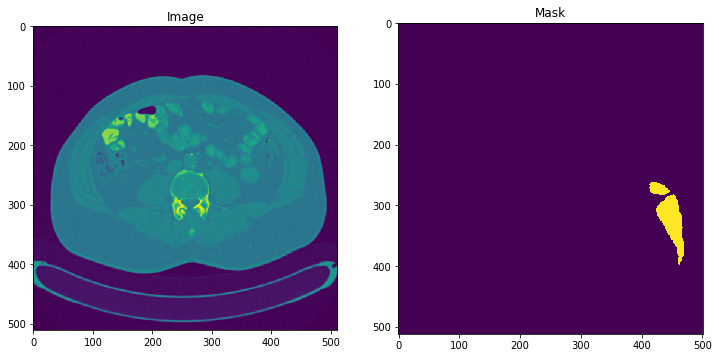

In [5]:
import nibabel as nib

def singleImageAndMask(slice_num):
    test_image=nib.load(all_images[slice_num]).get_data()
    test_mask=nib.load(all_masks[slice_num]).get_data()

    test_image = np.rollaxis(test_image, 2, 0)
    test_image = np.fliplr(np.flipud(np.swapaxes(test_image,1,2)))

#     test_mask = np.rollaxis(test_mask, 2, 0)
#     test_mask = np.fliplr(np.flipud(np.swapaxes(test_mask,1,2)))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
    ax1.imshow(test_image[test_image.shape[0]//2])
    ax1.set_title('Image')
    ax2.imshow(test_mask[test_image.shape[0]//2])
    ax2.set_title('Mask')

singleImageAndMask (2)    

# Display all views

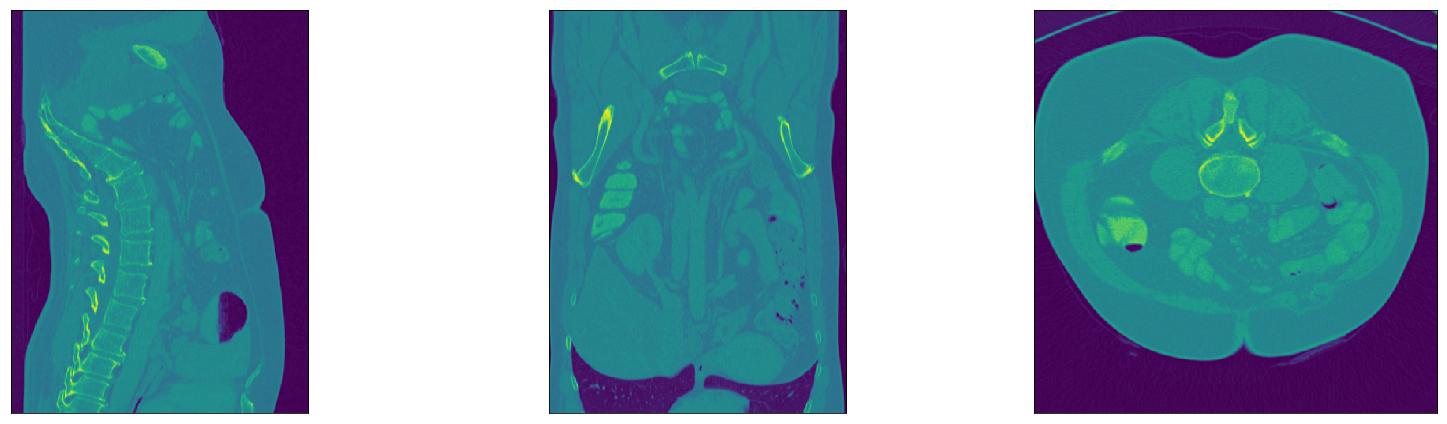

In [10]:
import nibabel as nb
# load nifti object
nii = nb.load(all_images[3])
# get nd array data
img = nii.get_data()

# get slices through middle of data
x, y, z = np.array(img.shape) // 2

fig, axes = plt.subplots(ncols=3, figsize=(24,6))
axes[0].imshow(img[x, ...].T, aspect=abs(nii.affine[2,2]/nii.affine[1,1]))
axes[1].imshow(img[:, y, :].T, aspect=abs(nii.affine[2,2]/nii.affine[0,0]))
axes[2].imshow(img[...,z].T, aspect=abs(nii.affine[1,1]/nii.affine[0,0]))

for ax in axes:
    ax.set_xticks(())
    ax.set_yticks(())

plt.tight_layout()

## Print a montage 

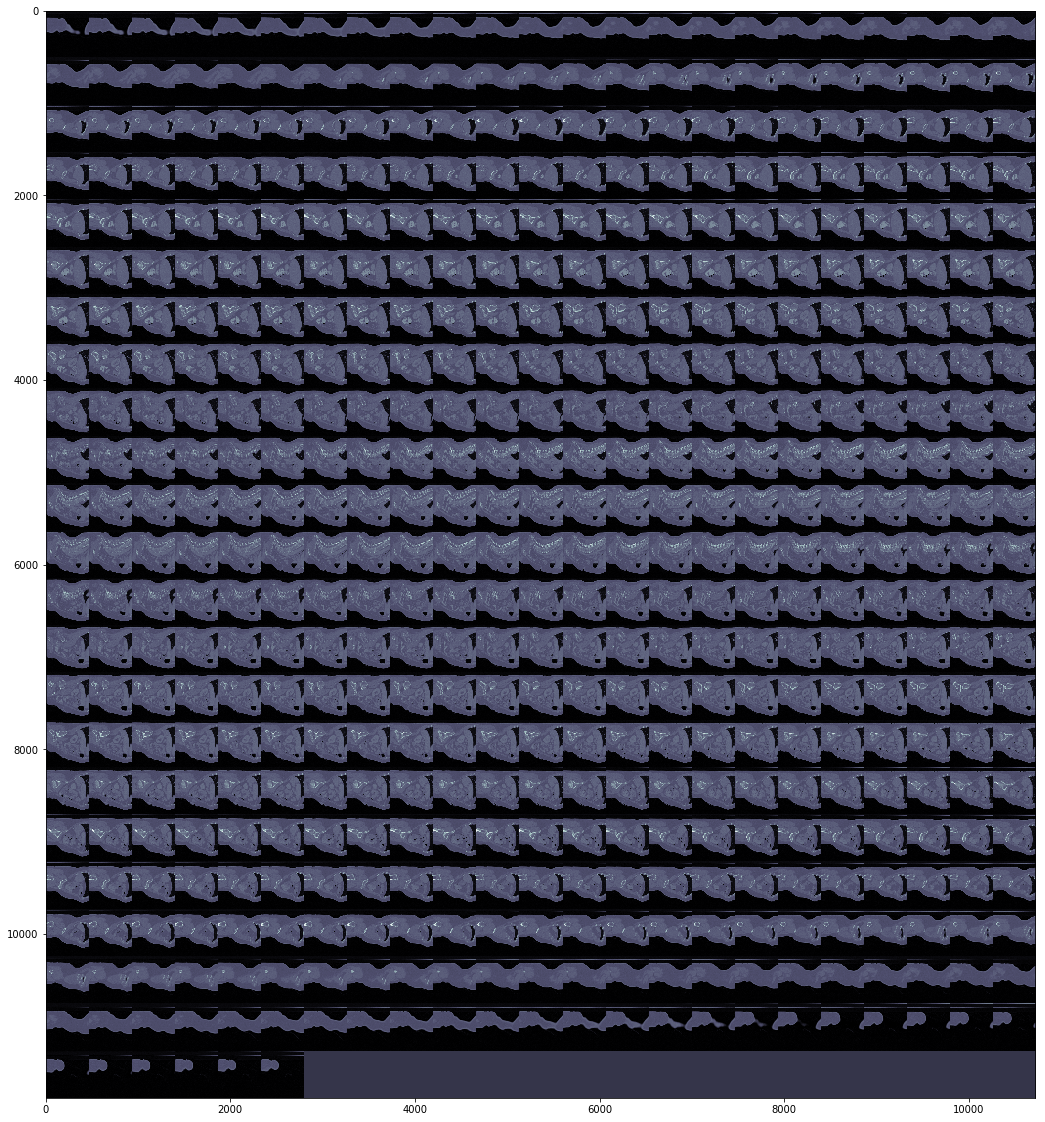

In [11]:
from skimage.util.montage import montage2d
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(montage2d(img), cmap ='bone')
fig.savefig('ct_scan.png')